In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

## 1. 首先，这个数据有一个总体的概览和探索。其中包括但不限于：

1. 对记录数的查看。
2. 对各个字段具体的含义：
    1. **更新日期（Date）**：表示数据记录的时间点，即该数据对应的时间范围的结束日期。（时间间隔大多数是 **7天**）
    2. **库存量（Stock，单位：万吨）**：该数据反映的是 **某个时间点的库存**（类似于存量数据），即 **统计周期的结束时点**，不是整个周期的累积量。
    3. **周度产量（Weekly Production，单位：万吨）**：表示 **每周** 山西地区的煤炭产量（即该周的总生产量）。

In [18]:
file_path = "data.xlsx"
df = pd.read_excel(file_path)

In [19]:
df.head(10)

,FW2024D-动力煤产销存（160家）,Unnamed: 1,Unnamed: 2
0,指标名称,山西-库存 (万吨),山西-周度产量 (万吨)
1,更新频率,周度,周度
2,值项,库存,周度产量
3,单位,万吨,万吨
4,数据来源,中国煤炭资源网,中国煤炭资源网
5,2024-07-31 00:00:00,106.1,363
6,2024-07-24 00:00:00,106.1,365
7,2024-07-17 00:00:00,105.2,364
8,2024-07-10 00:00:00,105.1,368
9,2024-07-03 00:00:00,108.4,386


In [20]:
df.tail(10)

,FW2024D-动力煤产销存（160家）,Unnamed: 1,Unnamed: 2
115,2022-06-21 00:00:00,115,392
116,2022-06-14 00:00:00,113.4,392
117,2022-06-07 00:00:00,113.2,392
118,2022-05-31 00:00:00,112,388
119,2022-05-24 00:00:00,112.3,402
120,2022-05-17 00:00:00,114.3,412
121,2022-05-10 00:00:00,115.3,414
122,2022-05-03 00:00:00,116.3,439
123,NaN,NaN,NaN
124,此数据下载自中国煤炭资源网（Sxcoal），使用请注明出处。,NaN,NaN


In [21]:
df = df.iloc[5:-2]

In [22]:
df.columns = ["Date", "Stock", "Weekly Production"]
df = df.reset_index(drop=True)

In [23]:
df

,Date,Stock,Weekly Production
0,2024-07-31 00:00:00,106.1,363
1,2024-07-24 00:00:00,106.1,365
2,2024-07-17 00:00:00,105.2,364
3,2024-07-10 00:00:00,105.1,368
4,2024-07-03 00:00:00,108.4,386
...,...,...,...
113,2022-05-31 00:00:00,112,388
114,2022-05-24 00:00:00,112.3,402
115,2022-05-17 00:00:00,114.3,412
116,2022-05-10 00:00:00,115.3,414


***

## 2. 然后，对各个字段的基础统计学信息进行了解和探索。包括但不限于：

### 1. 基础了解
基础了解：
   * **数据结构**（字段类型、行数、列数）
   * **时间跨度**（数据覆盖的时间范围）

In [24]:
# 将 Date 转换为 datetime 类型
df["Date"] = pd.to_datetime(df["Date"])

In [25]:
# 获取数据结构信息
data_info = df.info()
data_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               118 non-null    datetime64[ns]
 1   Stock              118 non-null    object        
 2   Weekly Production  118 non-null    object        
dtypes: datetime64[ns](1), object(2)
memory usage: 2.9+ KB


* Date: 时间数据 (datetime64[ns])
* Stock: 浮点数 (float64)
* Weekly Production: 整数 (int64)

In [28]:
# 计算数据行数和列数
num_rows, num_cols = df.shape
num_rows, num_cols

(118, 3)

* 数据总行数: 3
* 数据总列数: 3

In [27]:
# 计算时间跨度
date_range = (df["Date"].min(), df["Date"].max())
date_range

(Timestamp('2022-05-03 00:00:00'), Timestamp('2024-07-31 00:00:00'))

时间跨度：
* 起始日期: 2024-07-17
* 结束日期: 2024-07-31

***

### 2. 关键统计指标

关键统计指标：
   1. **库存量的均值、中位数、最大值、最小值、异常值**，并考虑处理
   2. **周度产量的均值、中位数、最大值、最小值、异常值**，并考虑处理
   3. **库存量和产量的变异性（标准差、变异系数）**

In [30]:
# 计算库存量的关键统计指标
stock_mean = df["Stock"].mean()
stock_median = df["Stock"].median()
stock_max = df["Stock"].max()
stock_min = df["Stock"].min()
stock_std = df["Stock"].std()
stock_cv = stock_std / stock_mean  # 变异系数

# 计算周度产量的关键统计指标
production_mean = df["Weekly Production"].mean()
production_median = df["Weekly Production"].median()
production_max = df["Weekly Production"].max()
production_min = df["Weekly Production"].min()
production_std = df["Weekly Production"].std()
production_cv = production_std / production_mean  # 变异系数

# 使用IQR（四分位距）方法检测异常值
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series < lower_bound) | (series > upper_bound)]

stock_outliers = detect_outliers(df["Stock"])
production_outliers = detect_outliers(df["Weekly Production"])

In [31]:
print(f"库存量的均值（Mean）：{stock_mean:.2f} 万吨")
print(f"库存量的中位数（Median）：{stock_median:.2f} 万吨")
print(f"库存量的最大值（Max）：{stock_max:.2f} 万吨")
print(f"库存量的最小值（Min）：{stock_min:.2f} 万吨")
print(f"库存量的标准差（Std Dev）：{stock_std:.2f} 万吨")
print(f"库存量的变异系数（CV）：{stock_cv:.6f}")
print(f"库存量的异常值（Outliers）：{stock_outliers.tolist()}")

print(f"周度产量的均值（Mean）：{production_mean:.2f} 万吨")
print(f"周度产量的中位数（Median）：{production_median:.2f} 万吨")
print(f"周度产量的最大值（Max）：{production_max} 万吨")
print(f"周度产量的最小值（Min）：{production_min} 万吨")
print(f"周度产量的标准差（Std Dev）：{production_std:.2f} 万吨")
print(f"周度产量的变异系数（CV）：{production_cv:.6f}")
print(f"周度产量的异常值（Outliers）：{production_outliers.tolist()}")

库存量的均值（Mean）：118.62 万吨
库存量的中位数（Median）：118.05 万吨
库存量的最大值（Max）：134.00 万吨
库存量的最小值（Min）：102.80 万吨
库存量的标准差（Std Dev）：6.45 万吨
库存量的变异系数（CV）：0.054368
库存量的异常值（Outliers）：[]
周度产量的均值（Mean）：416.36 万吨
周度产量的中位数（Median）：412.50 万吨
周度产量的最大值（Max）：478 万吨
周度产量的最小值（Min）：346 万吨
周度产量的标准差（Std Dev）：27.21 万吨
周度产量的变异系数（CV）：0.065360
周度产量的异常值（Outliers）：[346]


从结果可以看出，对于周度产量的异常值（Outliers）：[346]。346 万吨的产量比正常值要低，可能是突发事件导致的异常。

在进行后续的趋势和相关性分析的时候，可以考虑用平均值来替代它。

In [32]:
# 计算去除异常值之后的均值
valid_production = df["Weekly Production"][df["Weekly Production"] != 346]
production_mean_no_outliers = valid_production.mean()

# 用平均值替换异常值
df.loc[df["Weekly Production"] == 346, "Weekly Production"] = production_mean_no_outliers

print(f"使用均值 {production_mean_no_outliers:.2f} 替换异常值 346")
print(df[df["Weekly Production"] == production_mean_no_outliers])

使用均值 416.96 替换了异常值 346
         Date  Stock Weekly Production
24 2024-02-14  109.2        416.957265


In [35]:
# 更新后结果输出

# 计算库存量的关键统计指标
stock_mean = df["Stock"].mean()
stock_median = df["Stock"].median()
stock_max = df["Stock"].max()
stock_min = df["Stock"].min()
stock_std = df["Stock"].std()
stock_cv = stock_std / stock_mean  # 变异系数

# 计算周度产量的关键统计指标
production_mean = df["Weekly Production"].mean()
production_median = df["Weekly Production"].median()
production_max = df["Weekly Production"].max()
production_min = df["Weekly Production"].min()
production_std = df["Weekly Production"].std()
production_cv = production_std / production_mean  # 变异系数

# 使用IQR（四分位距）方法检测异常值
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series < lower_bound) | (series > upper_bound)]

stock_outliers = detect_outliers(df["Stock"])
production_outliers = detect_outliers(df["Weekly Production"])


print(f"库存量的均值（Mean）：{stock_mean:.2f} 万吨")
print(f"库存量的中位数（Median）：{stock_median:.2f} 万吨")
print(f"库存量的最大值（Max）：{stock_max:.2f} 万吨")
print(f"库存量的最小值（Min）：{stock_min:.2f} 万吨")
print(f"库存量的标准差（Std Dev）：{stock_std:.2f} 万吨")
print(f"库存量的变异系数（CV）：{stock_cv:.6f}")
print(f"库存量的异常值（Outliers）：{stock_outliers.tolist()}")

print(f"周度产量的均值（Mean）：{production_mean:.2f} 万吨")
print(f"周度产量的中位数（Median）：{production_median:.2f} 万吨")
print(f"周度产量的最大值（Max）：{production_max} 万吨")
print(f"周度产量的最小值（Min）：{production_min} 万吨")
print(f"周度产量的标准差（Std Dev）：{production_std:.2f} 万吨")
print(f"周度产量的变异系数（CV）：{production_cv:.6f}")
print(f"周度产量的异常值（Outliers）：{production_outliers.tolist()}")

库存量的均值（Mean）：118.62 万吨
库存量的中位数（Median）：118.05 万吨
库存量的最大值（Max）：134.00 万吨
库存量的最小值（Min）：102.80 万吨
库存量的标准差（Std Dev）：6.45 万吨
库存量的变异系数（CV）：0.054368
库存量的异常值（Outliers）：[]
周度产量的均值（Mean）：416.96 万吨
周度产量的中位数（Median）：413.00 万吨
周度产量的最大值（Max）：478 万吨
周度产量的最小值（Min）：363 万吨
周度产量的标准差（Std Dev）：26.42 万吨
周度产量的变异系数（CV）：0.063357
周度产量的异常值（Outliers）：[]


***

### 3. 数据趋势分析
**数据趋势分析**。通过图形得到各个字段之间的关系趋势，如：
   * **库存量的趋势**（是上升还是下降？有无季节性？）
   * **周度产量的变化趋势**（是否存在周期性？）
   * **库存量和周度产量的关系** *（在后面详细分析）*

In [38]:
# 确保按照日期排序
df = df.sort_values("Date")

In [48]:
df

,Date,Stock,Weekly Production
117,2022-05-03,116.3,439
116,2022-05-10,115.3,414
115,2022-05-17,114.3,412
114,2022-05-24,112.3,402
113,2022-05-31,112,388
...,...,...,...
4,2024-07-03,108.4,386
3,2024-07-10,105.1,368
2,2024-07-17,105.2,364
1,2024-07-24,106.1,365


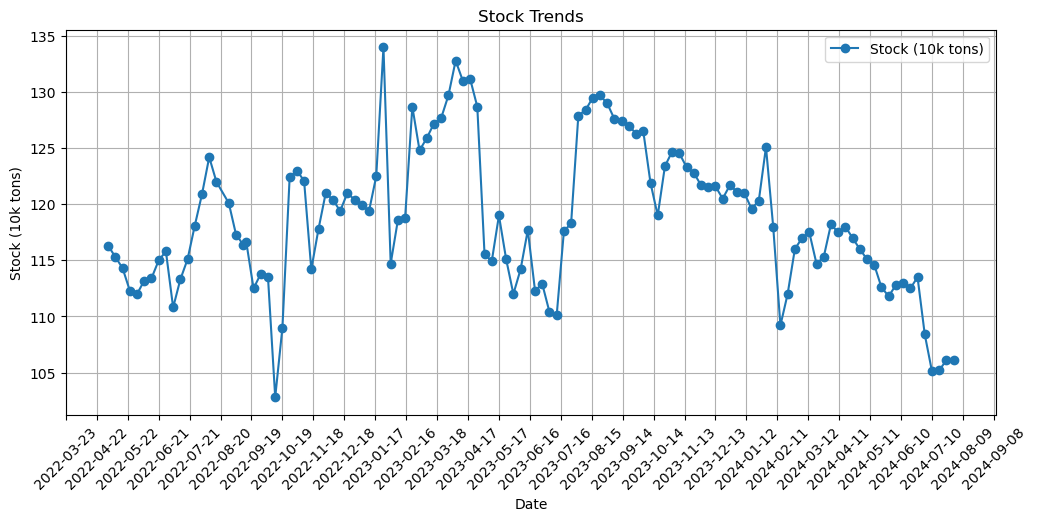

In [56]:
plt.figure(figsize=(12, 5))
plt.plot(df["Date"], df["Stock"], marker='o', linestyle='-', label="Stock (10k tons)")

plt.xlabel("Date")
plt.ylabel("Stock (10k tons)")
plt.title("Stock Trends")
plt.xticks(rotation=45)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

plt.legend()
plt.grid()
plt.show()

1. **总体趋势**

* 短期波动明显：总体表现出明显的短期波动，可能受市场需求、季节性因素或政策等方面的影响。
* 长期下降趋势：尽管存在波动，但整体库存量在2022年至2024年间呈下降趋势。

2. **季节性影响**

* 周期性高点：库存量大多在年底达到高峰，如2022年12月和2023年12月，可能与年底这段生产周期或市场需求相关。
* 周期性低点：库存量往往在年中达到低谷，如2022年7月和2023年7月，可能与季节性需求下降有关。

3. **其它**

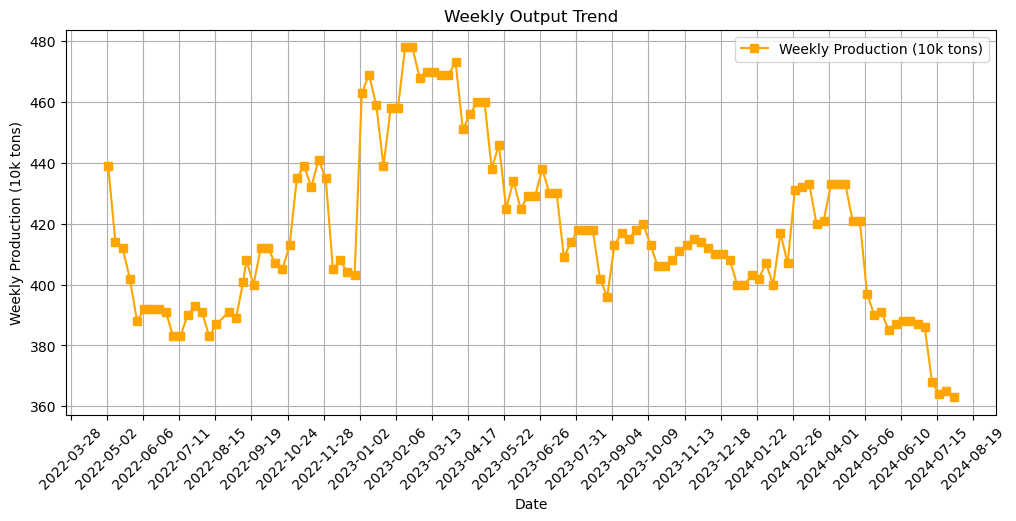

In [59]:
# 周度产量趋势
plt.figure(figsize=(12, 5))
plt.plot(df["Date"], df["Weekly Production"], marker='s', linestyle='-', label="Weekly Production (10k tons)", color='orange')

plt.xlabel("Date")
plt.ylabel("Weekly Production (10k tons)")
plt.title("Weekly Output Trend")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=5)) # 每隔5周
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # 显示格式 "YYYY-MM-DD"

plt.legend()
plt.grid()
plt.show()

**总体趋势：**
* 短期波动明显：产量在整个时间段内呈现周期性波动，可能受到季节性或市场需求的影响。
* 长期呈现下降趋势：
    * 2022-2023年：产量整体波动，但仍保持在 400-460 之间，没有出现大规模下降。
	* 2024年后：总体产量下滑，特别是 2024 年 3 月之后，下降至 360 附近，接近最低水平。

***

## 3. 对其中的相关性进行具体的分析

### 1. 时间序列趋势图

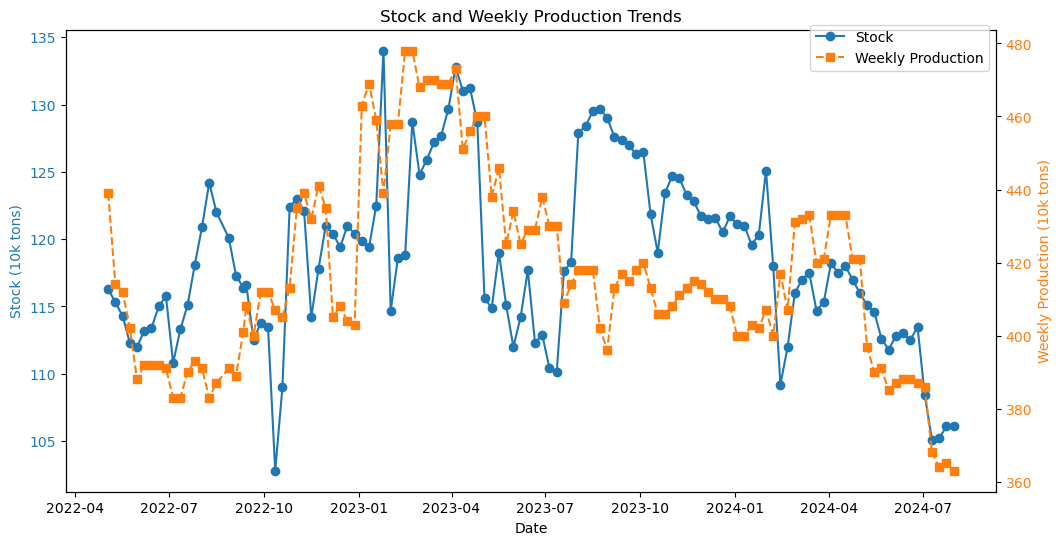

In [60]:
# 创建双轴图表
fig, ax1 = plt.subplots(figsize=(12, 6))

# 绘制库存量（左侧 Y 轴）
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock (10k tons)", color="tab:blue")
ax1.plot(df["Date"], df["Stock"], marker="o", linestyle="-", color="tab:blue", label="Stock")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# 创建右侧 Y 轴并绘制周度产量
ax2 = ax1.twinx()
ax2.set_ylabel("Weekly Production (10k tons)", color="tab:orange")
ax2.plot(df["Date"], df["Weekly Production"], marker="s", linestyle="--", color="tab:orange", label="Weekly Production")
ax2.tick_params(axis="y", labelcolor="tab:orange")

fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))

plt.xticks(rotation=45)

plt.title("Stock and Weekly Production Trends")

plt.show()

* 库存量和周度产量**整体上呈同步波动**，但产量的变化往往稍微领先于库存，说明库存的变化可能受到产量的直接影响。
* 库存量和周产量之间可能具有一定正相关性。
* ~~长期趋势：库存和产量均呈下降趋势。~~
* ~~2024年库存和产量急剧下降，可能受市场需求、供应链问题或政策影响。~~

### 2. 散点图

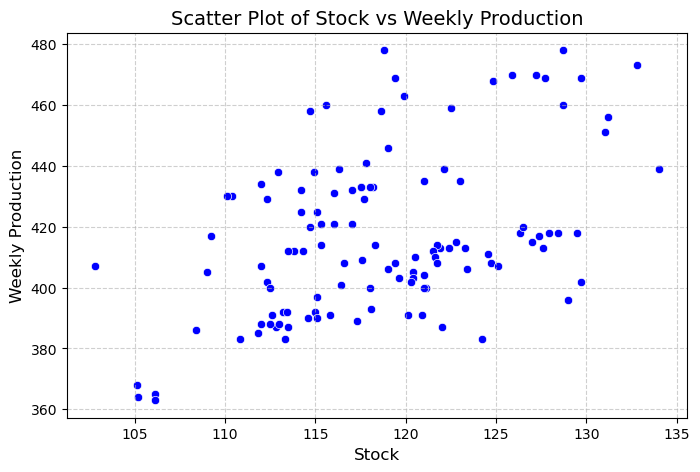

In [63]:
# 库存量与周产量的散点图
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["Stock"], y=df["Weekly Production"], color="blue", marker="o")

plt.title("Scatter Plot of Stock vs Weekly Production", fontsize=14)
plt.xlabel("Stock", fontsize=12)
plt.ylabel("Weekly Production", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

* 库存量和周产量没有形成完美的线性关系，但是总体呈现一定的正相关趋势。
* 库存量和周产量可能不是简单的线性关系，而是受多种因素影响（如市场需求、政策因素等）。

### 3. 计算相关性系数

In [68]:
# 皮尔逊相关系数
pearson_corr, pearson_pval = pearsonr(df["Stock"], df["Weekly Production"])
# 斯皮尔曼相关系数
spearman_corr, spearman_pval = spearmanr(df["Stock"], df["Weekly Production"])

correlation_results = pd.DataFrame({
    "Correlation Type": ["Pearson", "Spearman"],
    "Correlation Coefficient": [pearson_corr, spearman_corr],
    "P-Value": [pearson_pval, spearman_pval]
})
correlation_results 

,Correlation Type,Correlation Coefficient,P-Value
0,Pearson,0.468568,8.741815e-08
1,Spearman,0.409937,4.028198e-06


1. **皮尔逊相关性分析**

* 皮尔逊相关系数 r = 0.4686 表示 库存量和周产量之间有中等程度的正相关。
* P 值 远小于 0.05，说明相关性具有统计显著性，即不是随机噪声导致的。
* 说明库存量与周产量之间的影响关系可能还受到其它因素的影响。

2. **斯皮尔曼相关性分析**

* 斯皮尔曼相关系数 r_s = 0.4099 表示库存和周产量之间有中等程度的单调关系。
* P 值远小于 0.05，说明库存和周产量的单调关系是统计显著的，不是偶然现象。

3. **结论**

库存量和周产量之间有一定程度的正相关，但关系并不是特别强，也可能受其他因素影响。

## 4. 对它们的因果性进行具体的分析

**第 1 步：检查数据是否平稳**

In [70]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, name):
    result = adfuller(series)
    print(f"{name} - ADF Test:")
    print(f"Test Statistic: {result[0]}")
    print(f"P-Value: {result[1]}")
    print("-" * 40)

check_stationarity(df["Stock"], "Stock")
check_stationarity(df["Weekly Production"], "Weekly Production")

Stock - ADF Test:
Test Statistic: -3.2988077476620785
P-Value: 0.014931852392822109
----------------------------------------
Weekly Production - ADF Test:
Test Statistic: -1.8823665173381157
P-Value: 0.3404013810264769
----------------------------------------


结果分析：

| 变量                         | ADF 统计量 | P 值   | 平稳性判断 |
|-----------------------------|------------|--------|------------|
| Stock（库存量）            | -3.2988    | 0.0149 | 平稳  |
| Weekly Production（周产量） | -1.8824    | 0.3404 > 0.05 | 非平稳   |


可以看到：Weekly Production（周产量）的P 值0.3404原大于0.05，说明这个特征的数据是不平稳的。所以需要对Weekly Production（周产量）数据进行差分处理。

In [71]:
# 对非平稳的Weekly Production（周产量）进行处理
df["Weekly_Production_Diff"] = df["Weekly Production"].diff()

# 重新进行 ADF 检验
check_stationarity(df["Weekly_Production_Diff"].dropna(), "Weekly Production (Diff)")

Weekly Production (Diff) - ADF Test:
Test Statistic: -11.655719424559294
P-Value: 1.9877356662530575e-21
----------------------------------------


可以看到，差分后的结果的数据是平稳的。

**第 2 步：选择最佳的滞后期（Lag）**

In [77]:
df = df.dropna()

# 转换为数值型
df["Stock"] = pd.to_numeric(df["Stock"], errors="coerce")
df["Weekly Production"] = pd.to_numeric(df["Weekly Production"], errors="coerce")
df["Weekly_Production_Diff"] = pd.to_numeric(df["Weekly_Production_Diff"], errors="coerce")

print(df.dtypes)

Date                      datetime64[ns]
Stock                            float64
Weekly Production                float64
Weekly_Production_Diff           float64
dtype: object


/var/folders/qr/1hp7y80j3jx81qlcs3v3s3dr0000gn/T/ipykernel_56457/251222502.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Stock"] = pd.to_numeric(df["Stock"], errors="coerce")
/var/folders/qr/1hp7y80j3jx81qlcs3v3s3dr0000gn/T/ipykernel_56457/251222502.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Weekly Production"] = pd.to_numeric(df["Weekly Production"], errors="coerce")
/var/folders/qr/1hp7y80j3jx81qlcs3v3s3dr0000gn/T/ipykernel_56457/251222502.py:7: SettingWithCopyWarning: 
A value is t

In [78]:
from statsmodels.tsa.api import VAR

df_var = df[["Stock", "Weekly_Production_Diff"]].dropna()

# 选择最优滞后阶数（Lag）
model = VAR(df_var)
lag_order = model.select_order(maxlags=5)  # 设定最大滞后 5 周
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       8.526       8.575       5046.       8.546
1      7.589*      7.734*      1976.*      7.648*
2       7.650       7.893       2101.       7.749
3       7.611       7.950       2020.       7.748
4       7.615       8.052       2030.       7.793
5       7.667       8.201       2139.       7.884
-------------------------------------------------


/Users/psych0/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


可以看出：最佳滞后阶数（Lag）= 1。因为：
* AIC（计算模型的整体误差，考虑参数数量，越小越好） 最小（7.589）
* BIC（类似 AIC，但对模型复杂度惩罚更大，越小越好） 最小（7.734）
* FPE（直接衡量模型对新数据的预测误差，越小越好） 最小（1976）
* HQIC（介于 AIC 和 BIC 之间，越小越好） 最小（7.648）

**第 3 步：训练 VAR 模型**

In [79]:
# 训练 VAR 模型
var_model = VAR(df_var)
var_results = var_model.fit(1)  # 使用 lag = 1
print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 06, Mar, 2025
Time:                     11:48:35
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    7.68638
Nobs:                     116.000    HQIC:                   7.60177
Log likelihood:          -760.743    FPE:                    1889.33
AIC:                      7.54395    Det(Omega_mle):         1795.27
--------------------------------------------------------------------
Results for equation Stock
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            22.652903         6.814703            3.324           0.001
L1.Stock                          0.808742         0.057295           14.116           0.000
L1.Weekly_Pr

/Users/psych0/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


**结果简单分析：**

***

### Part I: Summary Results分析

```
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    7.68638
Nobs:                     116.000    HQIC:                   7.60177
Log likelihood:          -760.743    FPE:                    1889.33
AIC:                      7.54395    Det(Omega_mle):         1795.27
```

从结果可以看出：

* Nobs（样本数）为116，数据量相对适中，足够支撑 VAR 模型的估计，但样本量不算特别大。
* Log likelihood（对数似然值）为 -760.743，说明表明模型仍有改进空间，可能是因为 VAR(1) 的滞后阶数较少，或者变量间的关系较弱。
* AIC、BIC、FPE 均不算特别低，说明模型仍然有一定的误差和优化空间。
* FPE（最终预测误差）较大，说明预测的误差仍然较高。

***

### Part II: Results for equation Stock分析

```
Results for equation Stock
============================================================================================
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            22.652903         6.814703            3.324           0.001
L1.Stock                          0.808742         0.057295           14.116           0.000
L1.Weekly_Production_Diff         0.031331         0.033360            0.939           0.348
============================================================================================
```

从结果可以看出库存量（Stock）方程可以表示为：
Stock_t = 22.65 + 0.8087 \cdot Stock_{t-1} + 0.0313 \cdot Weekly_Production_Diff_{t-1}

整理后的结果如下：


| 变量                         | 系数（Coefficient） | 标准误差（Std. Error） | t 值（T-stat） | P 值（Prob） | 解释 |
|-----------------------------|-------------------|---------------------|--------------|------------|------------------------------------------------|
| 常数项（const）             | 22.65            | 6.81                | 3.32         | 0.001   | 显著，说明库存水平的长期均值偏高。              |
| L1.Stock（滞后 1 期的库存量） | 0.8087           | 0.057               | 14.12        | 0.000   | 库存量受到自身过去值的强烈影响（影响最大）。    |
| L1.Weekly_Production_Diff（滞后 1 期的周产量变化） | 0.0313 | 0.033 | 0.94 | 0.348 | 周产量的变化对库存的影响不显著。 |

可以看出：

* 库存量的主要影响因素是自己过去的值（P=0.000，系数=0.8087）。
* 短期产量变化对库存量影响不大（P=0.348，不显著）。

***

### Part III: Results for equation Weekly_Production_Diff分析

```
Results for equation Weekly_Production_Diff
============================================================================================
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                           -11.103994        18.754223           -0.592           0.554
L1.Stock                          0.089437         0.157676            0.567           0.571
L1.Weekly_Production_Diff        -0.068170         0.091808           -0.743           0.458
============================================================================================
```

从结果可以看出周产量变动（Weekly_Production_Diff）方程可以表示为：
\[
Weekly\Production\Diff_t = -11.10 + 0.0894 \cdot Stock{t-1} - 0.0681 \cdot Weekly_Production_Diff{t-1}
\]

整理后的结果如下：

| 变量 | 系数 (Coefficient) | P 值 (Prob) | 解释 |
|------|------------------|------------|------|
| 常数项 (const) | -11.10 | 0.554 | 不显著，没太大意义。 |
| L1.Stock（滞后 1 期的库存量） | 0.0894 | 0.571 | 库存对周产量变动无显著影响。 |
| L1.Weekly_Production_Diff（滞后 1 期的周产量变化） | -0.0681 | 0.458 | 产量变动的过去值对当前产量变动影响也不大。 |

可以看出：

* 库存量对产量变化没有显著影响（P=0.571，不显著）。
* 产量的变化主要不是由库存决定的，而可能受其他因素（如市场需求）影响。

***

### Part IV: Correlation matrix of residuals（残差相关性）分析

```
Correlation matrix of residuals
                             Stock  Weekly_Production_Diff
Stock                     1.000000                0.011234
Weekly_Production_Diff    0.011234                1.000000
```

从结果可以看出：

* 残差相关性非常低（0.011），说明误差项之间几乎没有关联。
* 所以可以认为 VAR 模型的两个方程是独立的，结果是可靠的。

**第 4 步：检查因果关系（Granger 检验）**

In [81]:
from statsmodels.tsa.stattools import grangercausalitytests

# 运行 Granger 因果检验，滞后阶数设为 1（根据 VAR 结果）
granger_result = grangercausalitytests(df_var, maxlag=1, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8820  , p=0.3496  , df_denom=113, df_num=1
ssr based chi2 test:   chi2=0.9055  , p=0.3413  , df=1
likelihood ratio test: chi2=0.9019  , p=0.3423  , df=1
parameter F test:         F=0.8820  , p=0.3496  , df_denom=113, df_num=1


/Users/psych0/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


从结果（F检验、卡方检验等）可以看出：

* 所有 P 值都大于 0.05，说明库存量和周产量变化之间没有明显的因果关系。
* 也就是说，库存量的过去值不能有效提高对周产量变化的预测能力。
* 表明库存量的变化可能主要受市场需求、订单量等因素影响，而不是短期产量变化的直接影响。

**第 5 步：用 VAR 预测未来**

In [82]:
forecast = var_results.forecast(df_var.values[-1:], steps=5)
print("未来 5 周预测值:")
print(forecast)

未来 5 周预测值:
[[108.39781825  -1.47836875]
 [110.27250463  -1.30841781]
 [111.79396783  -1.15233664]
 [113.02932991  -1.02690127]
 [114.03234969  -0.92496485]]


In [85]:
# 获取最新的真实周产量
last_real_weekly_production = df["Weekly Production"].iloc[-1]

# 逆差分（从 Weekly_Production_Diff 还原 Weekly Production）
predicted_weekly_production = [last_real_weekly_production]

for diff in forecast[:, 1]:  # 取 Weekly_Production_Diff 列
    next_value = predicted_weekly_production[-1] + diff  # 逆差分公式
    predicted_weekly_production.append(next_value)

# 删除第一个元素（因为它是已知的历史值）
predicted_weekly_production = predicted_weekly_production[1:]

# 打印未来 5 周的周产量预测值
print("未来 5 周周产量预测值:")
print(predicted_weekly_production)

未来 5 周周产量预测值:
[361.52163125403655, 360.2132134470441, 359.0608768041775, 358.03397553846736, 357.1090106849841]


In [92]:
# 合并数据
final_forecast = np.column_stack((forecast, predicted_weekly_production))
df_final = pd.DataFrame(final_forecast, columns=["Predicted Stock", "Predicted Weekly Production Diff", "Predicted Weekly Production"])
print(df_final)

   Predicted Stock  Predicted Weekly Production Diff  \
0       108.397818                         -1.478369   
1       110.272505                         -1.308418   
2       111.793968                         -1.152337   
3       113.029330                         -1.026901   
4       114.032350                         -0.924965   

   Predicted Weekly Production  
0                   361.521631  
1                   360.213213  
2                   359.060877  
3                   358.033976  
4                   357.109011  
